<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Proyecto Final
### Análisis de la reciente tendencia asociada a *Lana Rhoades* y su impacto en twitter
- Sebastian Vargas
- Sergio Siabato
- Danilo Plazas

## Autenticación con la API de Twitter

In [1]:
import json
import pandas as pd
pd.set_option('display.max_colwidth', None)
import tweepy

with open('credentials.json') as f:
    keys = json.load(f)

# Autenticar a través de la API 
auth = tweepy.OAuthHandler(keys['api_key'], keys['api_secret_key'])
auth.set_access_token(keys['access_token'], keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

##  Extracción de datos
Extraemos los tuits en español relacionados con la tematica de `Lana Rhoades` sin restricción de ubicación para el rango de fechas contenido entre el "31-05-2021" y "03-06-2021"

In [2]:
tweets = tweepy.Cursor(api.search,
                       q=['Lana Rhoades -RT'],
                       since='2021-05-31',
                       until='2021-06-03', 
                       lang='es',
                       #geocode='4.7110,-74.0721,100km',
                       tweet_mode='extended',
                       include_rts=False,
                       include_entities=True
                       ).items(3000)

## Preprocesamiento de datos
convertimos la respuesta de la api en un dataframe que contiene:
- **tweets**: texto explicito del tweets
- **date**: fecha en la que el tweet fue publicado
- **user_location**: ubicación del usuario que publico el tweet
- **id**: identificador único del tweet
- **link**: enlace directo al tweet en mención
- **likes**: cantidad de `me gusta` que ha recibido dicho tweet
- **img_url**: enlace asociado a la imagen publicada en el tweet (solo si tiene una)

In [3]:
# Objeto generador
t = [tweet for tweet in tweets]
t_processed = []

for tweet in t: 
    temp = []
    temp.append(tweet.full_text)
    temp.append(tweet.created_at)
    temp.append(tweet.user.location)
    temp.append(tweet.id)
    temp.append(f"https://twitter.com/i/web/status/{tweet.id}")
    temp.append(tweet.favorite_count)
    if "media" in tweet.entities:
        temp.append(tweet.entities["media"][0]["media_url"])
    t_processed.append(temp)
    
data = pd.DataFrame(t_processed)
data.columns = ['tweets', 'date', 'user_location', 'id', 'link', 'likes','img_url']
data.head()

,tweets,date,user_location,id,link,likes,img_url
0,"chingada madre,que rico debe estar ser el hijo de lana rhoades .____.",2021-06-02 23:32:45,,1400233959255166976,https://twitter.com/i/web/status/1400233959255166976,0,None
1,Oí jaja con eso pago 6 meses del only fans de Lana Rhoades que vale 5 dólares y está mucho mejor https://t.co/obpGrTlyGt,2021-06-02 23:32:25,,1400233873192144901,https://twitter.com/i/web/status/1400233873192144901,0,None
2,realmente hay gente emputada xq lana rhoades está embarazada????\nclaro pq las trabajadoras sexuales no son seres humanos sino simples objetos de consumo,2021-06-02 23:30:08,,1400233298174038016,https://twitter.com/i/web/status/1400233298174038016,1,None
3,Nadie.\nYo de la nada: ¿Y si muero y reencarno en el hijo de Lana Rhoades??,2021-06-02 23:29:20,,1400233100785954816,https://twitter.com/i/web/status/1400233100785954816,0,None
4,Lana rhoades embarazada* \n\nTodos mis amigos en el grupo: Voy a ser papa JAJAJAJA,2021-06-02 23:27:55,,1400232743779422212,https://twitter.com/i/web/status/1400232743779422212,0,None


El dataframe anterior le realizamos un proceso de limpieza y transformación donde tendremos:
- **tweets**: texto explicito del tweets
- **date**: fecha en la que el tweet fue publicado
- **img_url**: enlace asociado a la imagen publicada en el tweet (solo si tiene una)
- **likes**: cantidad de `me gusta` que ha recibido dicho tweet
- **texto_limpio**: texto del tweet luego de aplicar un proceso de eliminación de patrones de texto
- **links**: arreglo con los enlaces asociados al tweet
- **hashtags**: arreglo con los hashtags usados en el tweet
- **mentions**: arreglo con las menciones usadas en el tweet
- **emojis**: arreglo con los emojis usados en el tweet

In [35]:
import re
import regex
import emoji 

data = data[['tweets', 'date','img_url','likes']]

pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['tweets']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
    
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag, "")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention, "")
        
    return text, links, hashtags, mentions

def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)

    return emoji_list
  
  
data[['texto_limpio', 'links', 'hashtags', 'mentions']] = data.apply(text_clean, axis=1, result_type='expand')
data['emojis'] = data['texto_limpio'].apply(lambda text: get_emojis(text))
data.head()

,tweets,date,img_url,likes,texto_limpio,links,hashtags,mentions,emojis
0,"chingada madre,que rico debe estar ser el hijo de lana rhoades .____.",2021-06-02 23:32:45,None,0,"chingada madre,que rico debe estar ser el hijo de lana rhoades .____.",[],[],[],[]
1,Oí jaja con eso pago 6 meses del only fans de Lana Rhoades que vale 5 dólares y está mucho mejor https://t.co/obpGrTlyGt,2021-06-02 23:32:25,None,0,Oí jaja con eso pago 6 meses del only fans de Lana Rhoades que vale 5 dólares y está mucho mejor,[https://t.co/obpGrTlyGt],[],[],[]
2,realmente hay gente emputada xq lana rhoades está embarazada????\nclaro pq las trabajadoras sexuales no son seres humanos sino simples objetos de consumo,2021-06-02 23:30:08,None,1,realmente hay gente emputada xq lana rhoades está embarazada????\nclaro pq las trabajadoras sexuales no son seres humanos sino simples objetos de consumo,[],[],[],[]
3,Nadie.\nYo de la nada: ¿Y si muero y reencarno en el hijo de Lana Rhoades??,2021-06-02 23:29:20,None,0,Nadie.\nYo de la nada: ¿Y si muero y reencarno en el hijo de Lana Rhoades??,[],[],[],[]
4,Lana rhoades embarazada* \n\nTodos mis amigos en el grupo: Voy a ser papa JAJAJAJA,2021-06-02 23:27:55,None,0,Lana rhoades embarazada* \n\nTodos mis amigos en el grupo: Voy a ser papa JAJAJAJA,[],[],[],[]


##  Visualización descriptiva de los tweets
Inicialmente vamos a representar la evolución de los tweets en el tiempo, tomando como base la cantidad de tweets publicados por cada hora entre el "31-05-2021" y "03-06-2021"; posterior a lo anterior mostraremos cuales son los emojis mas usados en el conjunto de tweets extraidos

In [24]:
data['hora'] = data['date'].dt.floor('60T').astype(str)#.dt.time
temp = pd.DataFrame(data.hora.value_counts()).reset_index()
temp.columns = ['hora', 'cnt']
temp = temp.sort_values('hora')
# temp

In [26]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)


trace = go.Scatter(x=temp.hora.values,
                   y=temp.cnt.values,
                   text=[f"Fecha: {f}<br>Tuits: {c}" for f,c in zip(temp.hora.values,temp.cnt.values)],
                   hoverinfo='text',
                   mode='lines+markers',
                   name='Horas',
                   line={'color': 'blue'})

layout = go.Layout(title="Número de tuits por cada hora (31-May a 3-Jun)")

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [8]:
from collections import Counter

temp_emojis = pd.DataFrame(list(zip(Counter(sum(data.emojis.values,[])).keys(),Counter(sum(data.emojis.values,[])).values())))
temp_emojis.columns = ['emoji', 'cnt']
temp_emojis.sort_values('cnt', ascending=False, inplace=True)

trace = go.Bar(x=temp_emojis.emoji.values[:15],
               y=temp_emojis.cnt.values[:15])

layout = go.Layout(title='Emojis más usados')

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

En lo siguiente se trata de observar los tweets mas relevantes de todo el conjunto de tweets usando como criterio de ordenamiento la cantidad de "me gusta" recibidos y mostraremos algunos casos para dar un contexto mas amplio del tweet usando como base la imagen asociada al tweet.

In [9]:
data.sort_values(by="likes", ascending=False).head(10)

,tweets,date,img_url,likes,texto_limpio,links,hashtags,mentions,emojis,hora
1716,"""Lana Rhoades"":\nPorque anunció que está embarazada https://t.co/cti9dos769",2021-06-02 00:50:19,http://pbs.twimg.com/media/E21phlhWEAUIhRE.jpg,19683,"""Lana Rhoades"":\nPorque anunció que está embarazada",[https://t.co/cti9dos769],[],[],[],00:45:00
1819,*Lana rhoades sale embarazada*\n\nLas oficinas de brazzers: https://t.co/Ur4pxtozvV,2021-06-02 00:29:32,http://pbs.twimg.com/media/E21kxYrWEAcbtvD.jpg,7751,*Lana rhoades sale embarazada*\n\nLas oficinas de brazzers:,[https://t.co/Ur4pxtozvV],[],[],[],00:15:00
2043,El bebé de lana rhoades cuando nazca: https://t.co/5Be8Lm9Vop,2021-06-01 22:54:09,http://pbs.twimg.com/media/E21O8NXWQAIYSG9.jpg,6608,El bebé de lana rhoades cuando nazca:,[https://t.co/5Be8Lm9Vop],[],[],[],22:45:00
1631,Lana Rhoades: noooo hijooo no busques mi nombre en google https://t.co/sQY5pED1ZE,2021-06-02 01:03:45,http://pbs.twimg.com/media/E21smMdX0AELWSk.jpg,4823,Lana Rhoades: noooo hijooo no busques mi nombre en google,[https://t.co/sQY5pED1ZE],[],[],[],01:00:00
1637,El hijo de Lana Rhoades cuando googlee el nombre de su mamá: https://t.co/qiuQe2KU4k,2021-06-02 01:02:06,http://pbs.twimg.com/media/E21sOREXwAQFrUU.jpg,4742,El hijo de Lana Rhoades cuando googlee el nombre de su mamá:,[https://t.co/qiuQe2KU4k],[],[],[],01:00:00
1839,When te enteras ahora que Lana Rhoades está embarazada y el Cruz Azul Campeón https://t.co/xswiREBqHM,2021-06-02 00:24:53,http://pbs.twimg.com/media/E21jtRZX0AInxlC.jpg,3619,When te enteras ahora que Lana Rhoades está embarazada y el Cruz Azul Campeón,[https://t.co/xswiREBqHM],[],[],[],00:15:00
1992,"¡TERRIBLE NOTICIA! 🥺💔\n\nLana Rhoades está embarazada, llora el mundo entero. https://t.co/CN1wzj7K2f",2021-06-01 23:11:45,http://pbs.twimg.com/media/E21S99EXIAEXNDA.jpg,3020,"¡TERRIBLE NOTICIA! 🥺💔\n\nLana Rhoades está embarazada, llora el mundo entero.",[https://t.co/CN1wzj7K2f],[],[],"[🥺, 💔]",23:00:00
2033,Se embarazó Lana Rhoades: https://t.co/d4ycYkb5S3,2021-06-01 22:56:58,http://pbs.twimg.com/media/E21PlXZXMAEnLnO.jpg,2955,Se embarazó Lana Rhoades:,[https://t.co/d4ycYkb5S3],[],[],[],22:45:00
1701,@porquetendencia Cuando el pibe de Lana Rhoades crezca https://t.co/psVgkMjNNJ,2021-06-02 00:51:35,http://pbs.twimg.com/media/E21p0ZmXMAEWIPm.jpg,2682,Cuando el pibe de Lana Rhoades crezca,[https://t.co/psVgkMjNNJ],[],[@porquetendencia],[],00:45:00
2096,"Lana Rhoades acaba de anunciar que está embarazada. Salganse de twitter, quiero estar solo https://t.co/Db94pRuNmO",2021-06-01 22:36:30,http://pbs.twimg.com/media/E21K5SwXwAQHKdD.jpg,1956,"Lana Rhoades acaba de anunciar que está embarazada. Salganse de twitter, quiero estar solo",[https://t.co/Db94pRuNmO],[],[],[],22:30:00


<img src="http://pbs.twimg.com/media/E21O8NXWQAIYSG9.jpg" width="350" height="500"><img src="http://pbs.twimg.com/media/E21WjgtWUAAAbaa.jpg" width="350" height="500">

### Nube de palabras
Implementaremos una nube de palabras con todo el conjunto de tweets pero agregamos las palabras `Lana Rhoades` a los stopwords con el fin de excluirlo de nuestra visualización

In [10]:
import re
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import display
stopwords = stopwords.words("spanish")
stopwords.extend(["lana", "rhoades"])

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = [palabra for palabra in texto.split() if palabra not in stopwords]
    texto = " ".join(texto)
    return texto

data['pp'] = data.texto_limpio.apply(lambda texto: pre_procesado(texto))
palabras = data.pp.str.cat(sep=" ")

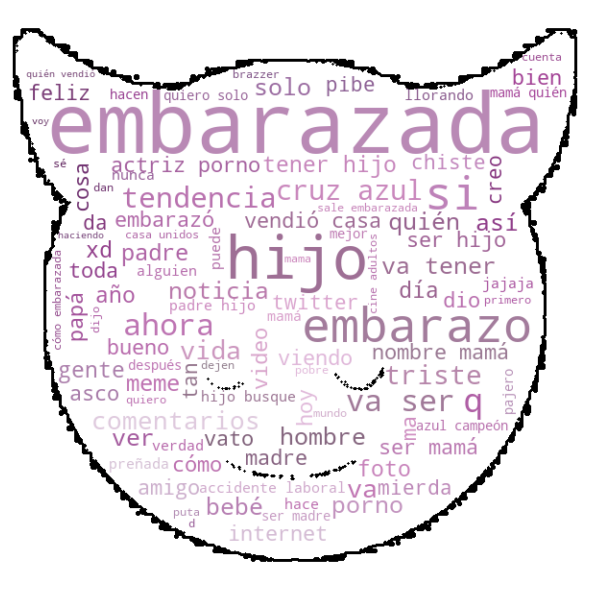

In [11]:
# CARGAR IMAGEN 
img = PIL.Image.open("emoji.jpg")
mask = np.array(img)

wordcloud = WordCloud(width=800, height=400,
                      max_font_size=150, max_words=100,
                      background_color="white", colormap="spring",
                      stopwords=stopwords, collocations=True,
                      mask=mask, contour_width=2, contour_color='black').generate(palabras) # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

image_colors=ImageColorGenerator(mask)

# wordcloud.to_file("test.png")

plt.figure(figsize=(10,8))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()